This notebook is aimed to use transfer learning to improve the accuracy of image classification. 

The inception model(https://arxiv.org/abs/1512.00567) was developed at Google to provide state of the art performance on the ImageNet Large-Scale Visual Recognition Challenge.

The code developed here is referred to https://github.com/Hvass-Labs/TensorFlow-Tutorials. 

In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import os
import time
from datetime import timedelta
import matplotlib.pyplot as plt

## Load the Data

In [2]:
data_root = './data/' 
pickle_file = os.path.join(data_root, 'data.pickle')

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)


Training set (395, 128, 128, 3) (395,)
Validation set (99, 128, 128, 3) (99,)


## Reformat into a TensorFlow-friendly shape
The inception needs the pixel between 0 and 255

In [3]:
width = 128
height = 128
num_labels = 5 # number of class labels
num_channels = 3 

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, height, width, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)


Training set (395, 128, 128, 3) (395, 5)
Validation set (99, 128, 128, 3) (99, 5)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/predictions.shape[0])

## Download and Load the Inception Model
* The transfer values are obtained by passing the images into the inception model.
* Then it will be used as the input data to the new classifier.
* This step will take a while, depending on the data size.

In [5]:
import inception

inception.maybe_download() # download incpetion model
model = inception.Inception() # load the Inception model

from inception import transfer_values_cache

file_path_cache_train = os.path.join(data_root, 'inception_train.pkl')
file_path_cache_validate = os.path.join(data_root, 'inception_validate.pkl')

print("Processing Inception transfer-values for training-images ...")
transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              images=train_dataset,
                                              model=model)

print("Processing Inception transfer-values for validate-images ...")
transfer_values_validate = transfer_values_cache(cache_path=file_path_cache_validate,
                                             images=valid_dataset,
                                             model=model)

print (transfer_values_train.shape)
print (transfer_values_validate.shape)


Data has apparently already been downloaded and unpacked.
Processing Inception transfer-values for training-images ...
- Processing image:    395 / 395
- Data saved to cache-file: ./blob_data3/inception_train.pkl
Processing Inception transfer-values for validate-images ...
- Processing image:     99 / 99
- Data saved to cache-file: ./blob_data3/inception_validate.pkl
(395, 2048)
(99, 2048)


## Plot the Input Image and Transfer-values for the Image using Inception Model

In [9]:
def plot_transfer_values(transfer_values, images, i):
    print("Input image:")
    
    # Plot the i'th image from the images dataset.
    plt.imshow(images[i]/255, interpolation='nearest')
    plt.show()

    print("Transfer-values for the image using Inception model:")
    
    # Transform the transfer-values into an image.
    img = transfer_values[i]
    img = img.reshape((32, 64))

    # Plot the image for the transfer-values.
    plt.imshow(img, interpolation='nearest', cmap='Reds')
    plt.show()

Input image:


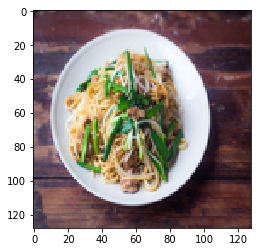

Transfer-values for the image using Inception model:


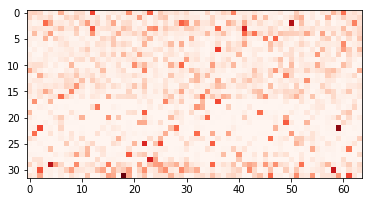

In [10]:
plot_transfer_values(transfer_values_validate,valid_dataset,17)

## Build a new Classifer
build a fully connected neural network as the last layer

In [11]:
transfer_len = int(inception.Inception().transfer_len)
num_hidden_nodes = 128 #set the num of hidden nodes in the fully connected neural network
batch_size = 16

graph = tf.Graph()

with graph.as_default():
    x = tf.placeholder(tf.float32, shape=[None, transfer_len], name='x')
    y_true = tf.placeholder(tf.float32, shape=[None, num_labels], name='y')
   
    tf_valid_dataset = tf.constant(transfer_values_validate)    
    w1 = tf.Variable(tf.random_normal([transfer_len,num_hidden_nodes], stddev = 0.03), name = 'w1')
    b1 = tf.Variable(tf.random_normal([num_hidden_nodes]),name = 'b1')
    w2 = tf.Variable(tf.random_normal([num_hidden_nodes, num_labels], stddev = 0.03), name = 'w2')
    b2 = tf.Variable(tf.random_normal([num_labels]),name = 'b2')
      
    def model(x):
        hidden_out = tf.add(tf.matmul(x,w1),b1)
        hidden_out = tf.nn.relu(hidden_out)   
        return tf.add(tf.matmul(hidden_out,w2),b2)
    
    # Training computation
    logits = model(x)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
      
    # Predictions for the training, and validation
    train_prediction = tf.nn.softmax(logits, name='restore_model')
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    
    # Save the model for future scoring
    saver = tf.train.Saver()

In [12]:
num_steps = 1001
num_epochs = 10

session = tf.Session()
session.run(tf.global_variables_initializer())
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for ite in range(num_epochs):
        permutation = np.random.permutation(train_labels.shape[0])
        shuffled_dataset = transfer_values_train[permutation,:]
        shuffled_labels = train_labels[permutation]
        for step in range(num_steps):
            offset = (step * batch_size) % (shuffled_labels.shape[0] - batch_size)
            batch_data = shuffled_dataset[offset:(offset + batch_size), :]
            batch_labels = shuffled_labels[offset:(offset + batch_size), :]
            feed_dict = {x : batch_data, y_true : batch_labels}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 50 == 0):
                print('Minibatch loss at iteration %d step %d: %f' % (ite, step, l))
                print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
    
    print('Validation dataset accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    valid_preds = valid_prediction.eval()
    
    # store the model
    save_dir = './model/'
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    checkpoint_path = os.path.join(save_dir, 'model')
    save_path=saver.save(session, checkpoint_path)
    print ('Model saved in file: %s'% save_path)

Initialized
Minibatch loss at iteration 0 step 0: 1.719679
Minibatch accuracy: 6.2%
Minibatch loss at iteration 0 step 50: 1.234572
Minibatch accuracy: 81.2%
Minibatch loss at iteration 0 step 100: 0.948798
Minibatch accuracy: 87.5%
Minibatch loss at iteration 0 step 150: 0.493773
Minibatch accuracy: 93.8%
Minibatch loss at iteration 0 step 200: 0.441596
Minibatch accuracy: 93.8%
Minibatch loss at iteration 0 step 250: 0.235281
Minibatch accuracy: 100.0%
Minibatch loss at iteration 0 step 300: 0.201557
Minibatch accuracy: 100.0%
Minibatch loss at iteration 0 step 350: 0.186901
Minibatch accuracy: 93.8%
Minibatch loss at iteration 0 step 400: 0.274800
Minibatch accuracy: 81.2%
Minibatch loss at iteration 0 step 450: 0.174269
Minibatch accuracy: 100.0%
Minibatch loss at iteration 0 step 500: 0.138601
Minibatch accuracy: 93.8%
Minibatch loss at iteration 0 step 550: 0.098777
Minibatch accuracy: 100.0%
Minibatch loss at iteration 0 step 600: 0.062443
Minibatch accuracy: 100.0%
Minibatch lo

Minibatch loss at iteration 5 step 200: 0.004674
Minibatch accuracy: 100.0%
Minibatch loss at iteration 5 step 250: 0.001164
Minibatch accuracy: 100.0%
Minibatch loss at iteration 5 step 300: 0.004377
Minibatch accuracy: 100.0%
Minibatch loss at iteration 5 step 350: 0.002084
Minibatch accuracy: 100.0%
Minibatch loss at iteration 5 step 400: 0.001756
Minibatch accuracy: 100.0%
Minibatch loss at iteration 5 step 450: 0.006220
Minibatch accuracy: 100.0%
Minibatch loss at iteration 5 step 500: 0.003724
Minibatch accuracy: 100.0%
Minibatch loss at iteration 5 step 550: 0.004745
Minibatch accuracy: 100.0%
Minibatch loss at iteration 5 step 600: 0.005282
Minibatch accuracy: 100.0%
Minibatch loss at iteration 5 step 650: 0.004385
Minibatch accuracy: 100.0%
Minibatch loss at iteration 5 step 700: 0.001032
Minibatch accuracy: 100.0%
Minibatch loss at iteration 5 step 750: 0.004635
Minibatch accuracy: 100.0%
Minibatch loss at iteration 5 step 800: 0.001791
Minibatch accuracy: 100.0%
Minibatch lo